Epoch 1/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - loss: 0.0285 - val_loss: 0.0218
Epoch 2/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0239 - val_loss: 0.0218
Epoch 3/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0235 - val_loss: 0.0218
Epoch 4/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0231 - val_loss: 0.0216
Epoch 5/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - loss: 0.0230 - val_loss: 0.0215
Epoch 6/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0232 - val_loss: 0.0215
Epoch 7/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0228 - val_loss: 0.0223
Epoch 8/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0233 - val_loss: 0.0216
Epoch 9/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0226 - val_loss: 0.0214
Epoch 10/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0224 - val_loss: 0.0215
Epoch 11/20
501/501 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0220 - val_loss: 0.0214
Epoch 12/20
501/501 ━━━━━━━━━━

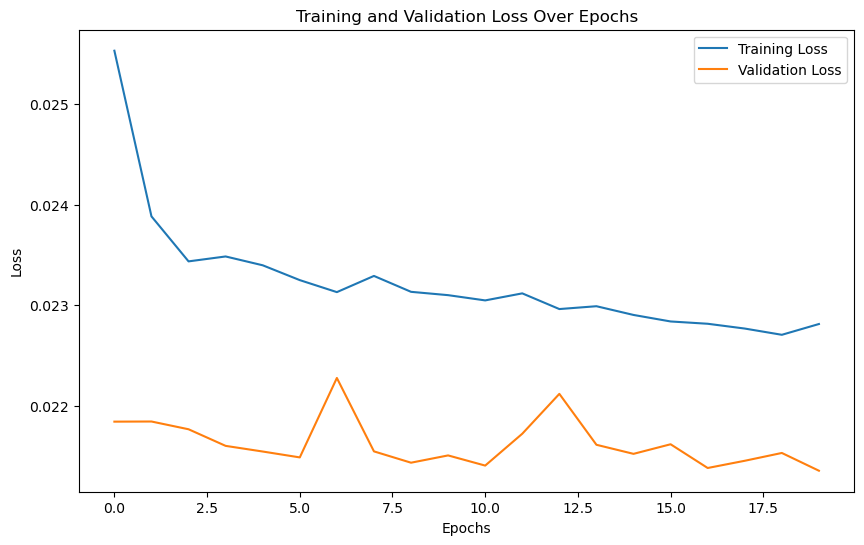

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test Mean Squared Error: 37.67622109705086
Test Mean Absolute Error: 4.833229946248217


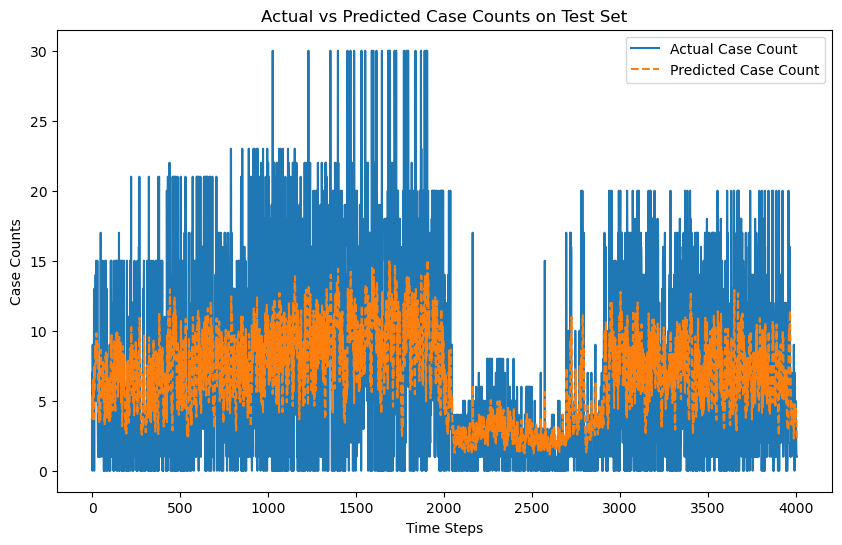

Predictions saved to 'lstm_predictions_output.csv'


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split

# Step 1: Load and preprocess your datasets
try:
    lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
    climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
    mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")

# Step 2: Preprocessing and Merging Datasets
lassa_fever_data_relevant = lassa_fever_data[['date_symptom_onset2', 'outcome_case', 'Stateofresidence_updated',
                                             'age_grouped', 'sex_new2', 'InitialSampleFinalLaboratoryResultPathogentest',
                                             'Symptomatic', 'fever_new', 'LGA_of_residence', 'geopolitical_zone',
                                             'case_classification_recode', 'first_symptom', 
                                             'present_condition', 'travelled_outside_district', 'date_onset_months',
                                             'educ_updatedcat', 'malaise_new', 'muscle_pain', 'difficulty_breathing',
                                             'bleeding_injection_site', 'bleeding_from_eyes',
                                             'bleeding_from_vagina', 'bleeding_gums', 'bleeding_bruising',
                                             'blood_in_stool', 'blackening_death_of', 'blood_urine',
                                             'bloody_black_stool']].copy()

case_counts = lassa_fever_data_relevant.groupby(['date_symptom_onset2', 'Stateofresidence_updated']).size().reset_index(name='case_count')
lassa_fever_data_relevant = lassa_fever_data_relevant.merge(case_counts, on=['date_symptom_onset2', 'Stateofresidence_updated'], how='left')
lassa_fever_data_relevant['case_count'].fillna(0, inplace=True)

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation', 'dew_point', 'surface_pressure']].copy()
mobility_data_relevant = mobility_data[['sub_region_1', 'sub_region_2', 'date', 'workplaces_percent_change_from_baseline',
                                       'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                                       'retail_and_recreation_percent_change_from_baseline']].copy()

mobility_data_relevant = mobility_data_relevant[mobility_data_relevant['sub_region_2'].isnull()]

lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)

lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

merged_data = pd.merge(lassa_fever_data_relevant, climatic_data_relevant, on=['state', 'date'], how='left')
merged_data = pd.merge(merged_data, mobility_data_relevant, on=['state', 'date'], how='left')

# Fill NaN values
merged_data['date'] = merged_data['date'].fillna(method='ffill')
merged_data['workplaces_percent_change_from_baseline'].fillna(merged_data['workplaces_percent_change_from_baseline'].mean(), inplace=True)
merged_data['residential_percent_change_from_baseline'].fillna(merged_data['residential_percent_change_from_baseline'].mean(), inplace=True)
merged_data['transit_stations_percent_change_from_baseline'].fillna(merged_data['transit_stations_percent_change_from_baseline'].mean(), inplace=True)
merged_data['retail_and_recreation_percent_change_from_baseline'].fillna(merged_data['retail_and_recreation_percent_change_from_baseline'].mean(), inplace=True)
merged_data['temperature'].fillna(merged_data['temperature'].mean(), inplace=True)
merged_data['humidity'].fillna(merged_data['humidity'].mean(), inplace=True)
merged_data['precipitation'].fillna(merged_data['precipitation'].mean(), inplace=True)
merged_data['dew_point'].fillna(merged_data['dew_point'].mean(), inplace=True)
merged_data['surface_pressure'].fillna(merged_data['surface_pressure'].mean(), inplace=True)

merged_data['sex_new2'].fillna(merged_data['sex_new2'].mode()[0], inplace=True)
merged_data['present_condition'].fillna('Alive', inplace=True)

# Step 3: Feature Engineering - Add Lagged Features and Rolling Windows
merged_data['case_count_lag1'] = merged_data['case_count'].shift(1)  # Lag of 1 day
merged_data['case_count_lag7'] = merged_data['case_count'].shift(7)  # Lag of 1 week
merged_data['case_count_avg7'] = merged_data['case_count'].rolling(window=7).mean()  # 7-day rolling average

# Add month_of_year feature based on the 'date' column
merged_data['month_of_year'] = merged_data['date'].dt.month

# Fill missing values for numeric columns with 0
numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(0)

# Step 4: Prepare the data for the LSTM model
features = ['case_count', 'case_count_lag1', 'case_count_lag7', 'case_count_avg7', 'temperature', 'humidity', 
            'precipitation', 'dew_point', 'surface_pressure', 'workplaces_percent_change_from_baseline', 
            'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 
            'retail_and_recreation_percent_change_from_baseline', 'month_of_year']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data[features])

# Convert scaled data back into DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=features)

# Step 5: Create time-series sequences for LSTM
time_step = 30  # 30 days look-back

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Predict 'case_count'
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_data_df.values, time_step)

# Step 6: Train/Test Split for Evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 7: Define the LSTM model
def create_model(units=100, dropout_rate=0.3):
    model = Sequential()
    model.add(Input(shape=(time_step, X.shape[2])))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the model with early stopping
model = create_model(units=100, dropout_rate=0.3)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Visualize Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 9: Make predictions on test data
predicted_cases_test = model.predict(X_test)

# Inverse transform predictions and actual values
dummy_scaled_test_data = np.zeros((predicted_cases_test.shape[0], scaled_data.shape[1]))
dummy_scaled_test_data[:, 0] = predicted_cases_test[:, 0]
predicted_cases_rescaled_test = scaler.inverse_transform(dummy_scaled_test_data)[:, 0]

dummy_scaled_actual_test = np.zeros((y_test.shape[0], scaled_data.shape[1]))
dummy_scaled_actual_test[:, 0] = y_test
actual_cases_rescaled_test = scaler.inverse_transform(dummy_scaled_actual_test)[:, 0]

# Step 10: Evaluate the model on the test set
mse_test = mean_squared_error(actual_cases_rescaled_test, predicted_cases_rescaled_test)
mae_test = mean_absolute_error(actual_cases_rescaled_test, predicted_cases_rescaled_test)

print(f"Test Mean Squared Error: {mse_test}")
print(f"Test Mean Absolute Error: {mae_test}")

# Step 11: Visualize Actual vs Predicted on Test Set
plt.figure(figsize=(10, 6))
plt.plot(actual_cases_rescaled_test, label='Actual Case Count')
plt.plot(predicted_cases_rescaled_test, label='Predicted Case Count', linestyle='--')
plt.title('Actual vs Predicted Case Counts on Test Set')
plt.xlabel('Time Steps')
plt.ylabel('Case Counts')
plt.legend()
plt.show()

# Step 12: Save the predictions and actual values to a CSV file for ensemble models
output_df = pd.DataFrame({
    'date': merged_data['date'].iloc[time_step + len(y_train):].values,  # Shift date to match test set predictions
    'state': merged_data['state'].iloc[time_step + len(y_train):].values,
    'actual_case_count': actual_cases_rescaled_test,
    'predicted_case_count': predicted_cases_rescaled_test
})

output_df.to_csv('/Users/m1/Downloads/lstm_predictions_output.csv', index=False)
print("Predictions saved to 'lstm_predictions_output.csv'")


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import TimeSeriesSplit

# Step 1: Load and preprocess your datasets (unchanged)
try:
    lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
    climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
    mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")

# Step 2: Preprocessing and Merging Datasets (unchanged)
lassa_fever_data_relevant = lassa_fever_data[['date_symptom_onset2', 'outcome_case', 'Stateofresidence_updated',
                                             'age_grouped', 'sex_new2', 'InitialSampleFinalLaboratoryResultPathogentest',
                                             'Symptomatic', 'fever_new', 'LGA_of_residence', 'geopolitical_zone',
                                             'case_classification_recode', 'first_symptom', 
                                             'present_condition', 'travelled_outside_district', 'date_onset_months',
                                             'educ_updatedcat', 'malaise_new', 'muscle_pain', 'difficulty_breathing',
                                             'bleeding_injection_site', 'bleeding_from_eyes',
                                             'bleeding_from_vagina', 'bleeding_gums', 'bleeding_bruising',
                                             'blood_in_stool', 'blackening_death_of', 'blood_urine',
                                             'bloody_black_stool']].copy()

case_counts = lassa_fever_data_relevant.groupby(['date_symptom_onset2', 'Stateofresidence_updated']).size().reset_index(name='case_count')
lassa_fever_data_relevant = lassa_fever_data_relevant.merge(case_counts, on=['date_symptom_onset2', 'Stateofresidence_updated'], how='left')
lassa_fever_data_relevant['case_count'].fillna(0, inplace=True)

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation', 'dew_point', 'surface_pressure']].copy()
mobility_data_relevant = mobility_data[['sub_region_1', 'sub_region_2', 'date', 'workplaces_percent_change_from_baseline',
                                       'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                                       'retail_and_recreation_percent_change_from_baseline']].copy()

mobility_data_relevant = mobility_data_relevant[mobility_data_relevant['sub_region_2'].isnull()]

lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)

lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

merged_data = pd.merge(lassa_fever_data_relevant, climatic_data_relevant, on=['state', 'date'], how='left')
merged_data = pd.merge(merged_data, mobility_data_relevant, on=['state', 'date'], how='left')

# Fill NaN values
merged_data['date'] = merged_data['date'].fillna(method='ffill')
merged_data['workplaces_percent_change_from_baseline'].fillna(merged_data['workplaces_percent_change_from_baseline'].mean(), inplace=True)
merged_data['residential_percent_change_from_baseline'].fillna(merged_data['residential_percent_change_from_baseline'].mean(), inplace=True)
merged_data['transit_stations_percent_change_from_baseline'].fillna(merged_data['transit_stations_percent_change_from_baseline'].mean(), inplace=True)
merged_data['retail_and_recreation_percent_change_from_baseline'].fillna(merged_data['retail_and_recreation_percent_change_from_baseline'].mean(), inplace=True)
merged_data['temperature'].fillna(merged_data['temperature'].mean(), inplace=True)
merged_data['humidity'].fillna(merged_data['humidity'].mean(), inplace=True)
merged_data['precipitation'].fillna(merged_data['precipitation'].mean(), inplace=True)
merged_data['dew_point'].fillna(merged_data['dew_point'].mean(), inplace=True)
merged_data['surface_pressure'].fillna(merged_data['surface_pressure'].mean(), inplace=True)

merged_data['sex_new2'].fillna(merged_data['sex_new2'].mode()[0], inplace=True)
merged_data['present_condition'].fillna('Alive', inplace=True)

# Step 3: Feature Engineering - Add Lagged Features and Rolling Windows
# Step 3: Feature Engineering - Add Lagged Features, Rolling Windows, and month_of_year
merged_data['case_count_lag1'] = merged_data['case_count'].shift(1)  # Lag of 1 day
merged_data['case_count_lag7'] = merged_data['case_count'].shift(7)  # Lag of 1 week
merged_data['case_count_avg7'] = merged_data['case_count'].rolling(window=7).mean()  # 7-day rolling average

# Add month_of_year feature based on the 'date' column
merged_data['month_of_year'] = merged_data['date'].dt.month

# Fill missing values for numeric columns with 0
numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(0)

# Fill missing values for categorical columns with the mode (safeguarded)
categorical_cols = merged_data.select_dtypes(include=['category', 'object']).columns
for col in categorical_cols:
    if not merged_data[col].mode().empty:
        merged_data[col] = merged_data[col].fillna(merged_data[col].mode()[0])

# Now, all missing values have been handled


# Step 4: Prepare the data for the LSTM model
features = ['case_count', 'case_count_lag1', 'case_count_lag7', 'case_count_avg7', 'temperature', 'humidity', 
            'precipitation', 'dew_point', 'surface_pressure', 'workplaces_percent_change_from_baseline', 
            'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 
            'retail_and_recreation_percent_change_from_baseline', 'month_of_year']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data[features])

# Convert scaled data back into DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=features)

# Step 5: Create time-series sequences for LSTM
time_step = 30  # 30 days look-back

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Predict 'case_count'
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_data_df.values, time_step)

# Step 6: TimeSeries Cross Validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Step 7: Define the LSTM model
def create_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Input(shape=(time_step, X.shape[2])))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Manually iterate over different hyperparameters
units = [50, 100, 150]
dropout_rates = [0.2, 0.3, 0.4]
batch_sizes = [16, 32, 64]
best_model = None
best_mse = float('inf')

for u in units:
    for d in dropout_rates:
        for batch_size in batch_sizes:
            print(f"Training model with {u} units, {d} dropout, {batch_size} batch size...")
            model = create_model(units=u, dropout_rate=d)
            model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, y_test))
            
            predicted_cases_test = model.predict(X_test)
            
            # Inverse transform predictions and actual values
            dummy_scaled_test_data = np.zeros((predicted_cases_test.shape[0], scaled_data.shape[1]))
            dummy_scaled_test_data[:, 0] = predicted_cases_test[:, 0]
            predicted_cases_rescaled_test = scaler.inverse_transform(dummy_scaled_test_data)[:, 0]
            
            dummy_scaled_actual_test = np.zeros((y_test.shape[0], scaled_data.shape[1]))
            dummy_scaled_actual_test[:, 0] = y_test
            actual_cases_rescaled_test = scaler.inverse_transform(dummy_scaled_actual_test)[:, 0]
            
            mse_test = mean_squared_error(actual_cases_rescaled_test, predicted_cases_rescaled_test)
            
            if mse_test < best_mse:
                best_mse = mse_test
                best_model = model
            
print(f"Best Test Mean Squared Error: {best_mse}")

# Step 8: Visualize Actual vs Predicted on Test Set
predicted_cases_test = best_model.predict(X_test)
dummy_scaled_test_data = np.zeros((predicted_cases_test.shape[0], scaled_data.shape[1]))
dummy_scaled_test_data[:, 0] = predicted_cases_test[:, 0]
predicted_cases_rescaled_test = scaler.inverse_transform(dummy_scaled_test_data)[:, 0]

dummy_scaled_actual_test = np.zeros((y_test.shape[0], scaled_data.shape[1]))
dummy_scaled_actual_test[:, 0] = y_test
actual_cases_rescaled_test = scaler.inverse_transform(dummy_scaled_actual_test)[:, 0]

plt.figure(figsize=(10, 6))
plt.plot(actual_cases_rescaled_test, label='Actual Case Count')
plt.plot(predicted_cases_rescaled_test, label='Predicted Case Count', linestyle='--')
plt.title('Actual vs Predicted Case Counts on Test Set')
plt.xlabel('Time Steps')
plt.ylabel('Case Counts')
plt.legend()
plt.show()


Training model with 50 units, 0.2 dropout, 16 batch size...
Epoch 1/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0282 - val_loss: 0.0247
Epoch 2/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0240 - val_loss: 0.0221
Epoch 3/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 4/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0224 - val_loss: 0.0218
Epoch 5/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0232 - val_loss: 0.0224
Epoch 6/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0223 - val_loss: 0.0221
Epoch 7/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0237 - val_loss: 0.0223
Epoch 8/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0232 - val_loss: 0.0220
Epoch 9/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0233 - val_loss: 0.0220
Epoch 10/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0229 - val_loss: 0.0221
Epoch 11/20
1044/1044 ━━━━━━━━━━━━━━━━━

1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0235 - val_loss: 0.0221
Epoch 5/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0227 - val_loss: 0.0230
Epoch 6/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0228 - val_loss: 0.0220
Epoch 7/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0231 - val_loss: 0.0218
Epoch 8/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0229 - val_loss: 0.0220
Epoch 9/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0228 - val_loss: 0.0222
Epoch 10/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0235 - val_loss: 0.0221
Epoch 11/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0236 - val_loss: 0.0223
Epoch 12/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0232 - val_loss: 0.0221
Epoch 13/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0224 - val_loss: 0.0220
Epoch 14/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0225 - val_loss: 0.0220
Epoch 15/20
1044

1044/1044 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0229 - val_loss: 0.0220
Epoch 8/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0231 - val_loss: 0.0225
Epoch 9/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0233 - val_loss: 0.0222
Epoch 10/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0233 - val_loss: 0.0219
Epoch 11/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0232 - val_loss: 0.0222
Epoch 12/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0232 - val_loss: 0.0220
Epoch 13/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0231 - val_loss: 0.0219
Epoch 14/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0221 - val_loss: 0.0218
Epoch 15/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0226 - val_loss: 0.0229
Epoch 16/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0223 - val_loss: 0.0219
Epoch 17/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0233 - val_loss: 0.0221
Epoch 18/20
1

1044/1044 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.0220 - val_loss: 0.0219
Epoch 11/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.0230 - val_loss: 0.0222
Epoch 12/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.0228 - val_loss: 0.0220
Epoch 13/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.0224 - val_loss: 0.0221
Epoch 14/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.0227 - val_loss: 0.0219
Epoch 15/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.0230 - val_loss: 0.0220
Epoch 16/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.0216 - val_loss: 0.0218
Epoch 17/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0221 - val_loss: 0.0218
Epoch 18/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0225 - val_loss: 0.0219
Epoch 19/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0221 - val_loss: 0.0226
Epoch 20/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0222 - val_loss: 0.0219
105/105 ━━━

1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0228 - val_loss: 0.0221
Epoch 14/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0224 - val_loss: 0.0219
Epoch 15/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0220 - val_loss: 0.0226
Epoch 16/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0227 - val_loss: 0.0219
Epoch 17/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0225 - val_loss: 0.0220
Epoch 18/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0223 - val_loss: 0.0219
Epoch 19/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0228 - val_loss: 0.0223
Epoch 20/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0226 - val_loss: 0.0219
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training model with 100 units, 0.3 dropout, 32 batch size...
Epoch 1/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0303 - val_loss: 0.0225
Epoch 2/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0239 - val_loss: 0.0222
Epoch 

1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0226 - val_loss: 0.0219
Epoch 17/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0227 - val_loss: 0.0221
Epoch 18/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0230 - val_loss: 0.0220
Epoch 19/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0226 - val_loss: 0.0218
Epoch 20/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0220 - val_loss: 0.0219
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training model with 100 units, 0.4 dropout, 32 batch size...
Epoch 1/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.0280 - val_loss: 0.0234
Epoch 2/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0239 - val_loss: 0.0220
Epoch 3/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0230 - val_loss: 0.0218
Epoch 4/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0231 - val_loss: 0.0222
Epoch 5/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0235 - val_loss: 0.0221
Epoch 6/20
522/

KeyboardInterrupt: 

In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Step 1: Load and preprocess your datasets
try:
    lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
    climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
    mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")

# Step 2: Select relevant columns and preprocess
lassa_fever_data_relevant = lassa_fever_data[['date_symptom_onset2', 'outcome_case', 'Stateofresidence_updated',
                                             'age_grouped', 'sex_new2', 'InitialSampleFinalLaboratoryResultPathogentest',
                                             'Symptomatic', 'fever_new', 'LGA_of_residence', 'geopolitical_zone',
                                             'case_classification_recode', 'first_symptom', 
                                             'present_condition', 'travelled_outside_district', 'date_onset_months',
                                             'educ_updatedcat', 'malaise_new', 'muscle_pain', 'difficulty_breathing',
                                             'bleeding_injection_site', 'bleeding_from_eyes',
                                             'bleeding_from_vagina', 'bleeding_gums', 'bleeding_bruising',
                                             'blood_in_stool', 'blackening_death_of', 'blood_urine',
                                             'bloody_black_stool']].copy()

# Create 'case_count' by aggregating data
case_counts = lassa_fever_data_relevant.groupby(['date_symptom_onset2', 'Stateofresidence_updated']).size().reset_index(name='case_count')
lassa_fever_data_relevant = lassa_fever_data_relevant.merge(case_counts, on=['date_symptom_onset2', 'Stateofresidence_updated'], how='left')
lassa_fever_data_relevant['case_count'].fillna(0, inplace=True)

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation', 'dew_point', 'surface_pressure']].copy()
mobility_data_relevant = mobility_data[['sub_region_1', 'sub_region_2', 'date', 'workplaces_percent_change_from_baseline',
                                       'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                                       'retail_and_recreation_percent_change_from_baseline']].copy()

# Filter to keep only rows where sub_region_2 is null
mobility_data_relevant = mobility_data_relevant[mobility_data_relevant['sub_region_2'].isnull()]

# Step 3: Merge and align the datasets
# Rename columns for consistency
lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)
# Convert date columns to datetime
lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

# Merge the datasets on 'state' and 'date'
merged_data = pd.merge(lassa_fever_data_relevant, climatic_data_relevant, on=['state', 'date'], how='left')
merged_data = pd.merge(merged_data, mobility_data_relevant, on=['state', 'date'], how='left')

# Fill NaN values
merged_data['date'] = merged_data['date'].fillna(method='ffill')
merged_data['workplaces_percent_change_from_baseline'].fillna(merged_data['workplaces_percent_change_from_baseline'].mean(), inplace=True)
merged_data['residential_percent_change_from_baseline'].fillna(merged_data['residential_percent_change_from_baseline'].mean(), inplace=True)
merged_data['transit_stations_percent_change_from_baseline'].fillna(merged_data['transit_stations_percent_change_from_baseline'].mean(), inplace=True)
merged_data['retail_and_recreation_percent_change_from_baseline'].fillna(merged_data['retail_and_recreation_percent_change_from_baseline'].mean(), inplace=True)
merged_data['temperature'].fillna(merged_data['temperature'].mean(), inplace=True)
merged_data['humidity'].fillna(merged_data['humidity'].mean(), inplace=True)
merged_data['precipitation'].fillna(merged_data['precipitation'].mean(), inplace=True)
merged_data['dew_point'].fillna(merged_data['dew_point'].mean(), inplace=True)
merged_data['surface_pressure'].fillna(merged_data['surface_pressure'].mean(), inplace=True)

# Standardizing categorical columns
merged_data['sex_new2'].fillna(merged_data['sex_new2'].mode()[0], inplace=True)
merged_data['present_condition'].fillna('Alive', inplace=True)

# Step 4: Prepare the data for the LSTM model
features = ['case_count', 'temperature', 'humidity', 'precipitation', 'dew_point', 'surface_pressure',
            'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
            'transit_stations_percent_change_from_baseline', 'retail_and_recreation_percent_change_from_baseline']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data[features])

# Convert scaled data back into DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=features)

# Step 5: Create time-series sequences for LSTM
time_step = 30  # Example: 30 days for each sequence

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Predict 'case_count'
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_data_df.values, time_step)

# Reshape the data for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Step 6: Build and train the LSTM model
model = Sequential()

# Use Input layer for input shape definition
model.add(Input(shape=(time_step, X.shape[2])))

# LSTM layers and dropout layers
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected layers
model.add(Dense(25))
model.add(Dense(1))  # Output layer for 'case_count'

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=10, batch_size=32)

# Step 7: Make predictions
predicted_cases = model.predict(X)

# Inverse transform to get actual case counts
predicted_cases_rescaled = scaler.inverse_transform(np.hstack((predicted_cases, np.zeros((predicted_cases.shape[0], scaled_data.shape[1] - 1)))))[:, 0]

# Step 8: Save the predictions to a CSV file
output_df = pd.DataFrame({
    'date': merged_data['date'][time_step:],  # Shift date to match predictions
    'state': merged_data['state'][time_step:],
    'predicted_case_count': predicted_cases_rescaled
})

# Save the output to a CSV file
output_df.to_csv('/Users/m1/Downloads/lstm_predictions_output.csv', index=False)

print("Predictions saved to 'lstm_predictions_output.csv'")

# Step 9: Evaluate the model performance
mse = mean_squared_error(y, predicted_cases)
mae = mean_absolute_error(y, predicted_cases)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Epoch 1/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0300
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0234
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0229
Epoch 4/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0237
Epoch 5/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0233
Epoch 6/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0232
Epoch 7/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0224
Epoch 8/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0232
Epoch 9/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.0232
Epoch 10/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0225
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Predictions saved to 'lstm_predictions_output.csv'
Mean Squared Error: 0.022635537389980656
Mean Absolute Error: 0.10613464541236749


In [107]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Load and preprocess your datasets
try:
    lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
    climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
    mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")

# Step 2: Select relevant columns and preprocess
lassa_fever_data_relevant = lassa_fever_data[['date_symptom_onset2', 'outcome_case', 'Stateofresidence_updated',
                                             'age_grouped', 'sex_new2', 'InitialSampleFinalLaboratoryResultPathogentest',
                                             'Symptomatic', 'fever_new', 'LGA_of_residence', 'geopolitical_zone',
                                             'case_classification_recode', 'first_symptom', 
                                             'present_condition', 'travelled_outside_district', 'date_onset_months',
                                             'educ_updatedcat', 'malaise_new', 'muscle_pain', 'difficulty_breathing',
                                             'bleeding_injection_site', 'bleeding_from_eyes',
                                             'bleeding_from_vagina', 'bleeding_gums', 'bleeding_bruising',
                                             'blood_in_stool', 'blackening_death_of', 'blood_urine',
                                             'bloody_black_stool']].copy()

# Create 'case_count' by aggregating data
case_counts = lassa_fever_data_relevant.groupby(['date_symptom_onset2', 'Stateofresidence_updated']).size().reset_index(name='case_count')
lassa_fever_data_relevant = lassa_fever_data_relevant.merge(case_counts, on=['date_symptom_onset2', 'Stateofresidence_updated'], how='left')
lassa_fever_data_relevant['case_count'].fillna(0, inplace=True)

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation', 'dew_point', 'surface_pressure']].copy()
mobility_data_relevant = mobility_data[['sub_region_1', 'sub_region_2', 'date', 'workplaces_percent_change_from_baseline',
                                       'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                                       'retail_and_recreation_percent_change_from_baseline']].copy()

# Filter to keep only rows where sub_region_2 is null
mobility_data_relevant = mobility_data_relevant[mobility_data_relevant['sub_region_2'].isnull()]

# Step 3: Merge and align the datasets
# Rename columns for consistency
lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)
# Convert date columns to datetime
lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

# Standardize the location column names


# Merge the datasets on 'state' and 'date'
merged_data = pd.merge(lassa_fever_data_relevant, climatic_data_relevant, on=['state', 'date'], how='left')
merged_data = pd.merge(merged_data, mobility_data_relevant, on=['state', 'date'], how='left')

merged_data['date'] = merged_data['date'].fillna(method='ffill')
merged_data['workplaces_percent_change_from_baseline'].fillna(merged_data['workplaces_percent_change_from_baseline'].mean(), inplace=True)
merged_data['residential_percent_change_from_baseline'].fillna(merged_data['residential_percent_change_from_baseline'].mean(), inplace=True)
merged_data['transit_stations_percent_change_from_baseline'].fillna(merged_data['transit_stations_percent_change_from_baseline'].mean(), inplace=True)
merged_data['retail_and_recreation_percent_change_from_baseline'].fillna(merged_data['retail_and_recreation_percent_change_from_baseline'].mean(), inplace=True)
merged_data['temperature'].fillna(merged_data['temperature'].mean(), inplace=True)
merged_data['humidity'].fillna(merged_data['humidity'].mean(), inplace=True)
merged_data['precipitation'].fillna(merged_data['precipitation'].mean(), inplace=True)
merged_data['dew_point'].fillna(merged_data['dew_point'].mean(), inplace=True)
merged_data['surface_pressure'].fillna(merged_data['surface_pressure'].mean(), inplace=True)
merged_data['sex_new2'].fillna(merged_data['sex_new2'].mode()[0], inplace=True)
merged_data['LGA_of_residence'].fillna(merged_data['LGA_of_residence'].mode()[0], inplace=True)
merged_data['geopolitical_zone'].fillna(merged_data['geopolitical_zone'].mode()[0], inplace=True)
merged_data['case_classification_recode'].fillna(merged_data['case_classification_recode'].mode()[0], inplace=True)
merged_data['first_symptom'].fillna(merged_data['first_symptom'].mode()[0], inplace=True)
merged_data['fever_new'].fillna('No', inplace=True)
merged_data['muscle_pain'].fillna('No', inplace=True)
merged_data['malaise_new'].fillna('No', inplace=True)
merged_data['difficulty_breathing'].fillna('No', inplace=True)
merged_data['bleeding_injection_site'].fillna('No', inplace=True) 
merged_data['bleeding_from_eyes'].fillna('No', inplace=True) 
merged_data['bleeding_from_vagina'].fillna('No', inplace=True)
merged_data['bleeding_gums'].fillna('No', inplace=True)
merged_data['bleeding_bruising'].fillna('No', inplace=True)
merged_data['blood_in_stool'].fillna('No', inplace=True)
merged_data['blackening_death_of'].fillna('No', inplace=True)
merged_data['blood_urine'].fillna('No', inplace=True)
merged_data['bloody_black_stool'].fillna('No', inplace=True)
merged_data['present_condition'].fillna('Alive', inplace=True)
merged_data['date_onset_months'].fillna(merged_data['date_onset_months'].median(), inplace=True)

# Drop unnecessary columns and handle missing values
merged_data.drop(columns=['sub_region_2'], inplace=True)

# Step 4: Prepare the data for the LSTM model
features = ['case_count', 'temperature', 'humidity', 'precipitation', 'dew_point', 'surface_pressure',
            'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
            'transit_stations_percent_change_from_baseline', 'retail_and_recreation_percent_change_from_baseline']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data[features])

# Convert scaled data back into DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=features)

# Step 5: Create time-series sequences for LSTM
time_step = 30  # Example: 30 days for each sequence

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Predict 'case_count'
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_data_df.values, time_step)

# Reshape the data for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Step 6: Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))  # Output layer for 'case_count'

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X, y, epochs=10, batch_size=32)

# Step 7: Make predictions
predicted_cases = model.predict(X)

# Inverse transform to get actual case counts
predicted_cases_rescaled = scaler.inverse_transform(predicted_cases)

# Step 8: Save the predictions to a CSV file
output_df = pd.DataFrame({
    'date': merged_data['date'][time_step:],  # Shift date to match predictions
    'state': merged_data['state'][time_step:],
    'predicted_case_count': predicted_cases_rescaled[:, 0]
})

# Save the output to a CSV file
output_df.to_csv('/Users/m1/Downloads/lstm_predictions_output.csv', index=False)

print("Predictions saved to 'lstm_predictions_output.csv'")


Epoch 1/10


/Users/m1/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


626/626 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0286
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0238
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0227
Epoch 4/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0231
Epoch 5/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0234
Epoch 6/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0227
Epoch 7/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0228
Epoch 8/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0230
Epoch 9/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0222
Epoch 10/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0230
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


ValueError: non-broadcastable output operand with shape (20032,1) doesn't match the broadcast shape (20032,10)

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load and preprocess your datasets
try:
    lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
    climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
    mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")

# Step 2: Select relevant columns and preprocess
lassa_fever_data_relevant = lassa_fever_data[['date_symptom_onset2', 'outcome_case', 'Stateofresidence_updated',
                                             'age_grouped', 'sex_new2', 'InitialSampleFinalLaboratoryResultPathogentest',
                                             'Symptomatic', 'fever_new', 'LGA_of_residence', 'geopolitical_zone',
                                             'case_classification_recode', 'first_symptom', 
                                             'present_condition', 'travelled_outside_district', 'date_onset_months',
                                             'educ_updatedcat', 
                                             'malaise_new', 'muscle_pain', 'difficulty_breathing',
                                             'bleeding_injection_site', 'bleeding_from_eyes',
                                             'bleeding_from_vagina', 'bleeding_gums', 'bleeding_bruising',
                                             'blood_in_stool', 'blackening_death_of', 'blood_urine',
                                             'bloody_black_stool']].copy()

# Create 'case_count' by aggregating data if needed
case_counts = lassa_fever_data_relevant.groupby(['date_symptom_onset2', 'Stateofresidence_updated']).size().reset_index(name='case_count')
lassa_fever_data_relevant = lassa_fever_data_relevant.merge(case_counts, on=['date_symptom_onset2', 'Stateofresidence_updated'], how='left')
# Fill NaN values in case_count with 0
lassa_fever_data_relevant['case_count'].fillna(0, inplace=True)

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation', 'dew_point', 'surface_pressure']].copy()
mobility_data_relevant = mobility_data[['sub_region_1', 'sub_region_2', 'date', 'workplaces_percent_change_from_baseline',
                                       'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                                       'retail_and_recreation_percent_change_from_baseline']].copy()

In [35]:
# Filter to keep only rows where sub_region_2 is null
mobility_data_relevant = mobility_data_relevant[mobility_data_relevant['sub_region_2'].isnull()]
    
# Rename columns for consistency
lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)

# Convert date columns to datetime
lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

# Merge datasets
merged_data = lassa_fever_data_relevant.merge(climatic_data_relevant, on=['state', 'date'], how='left')
merged_data = merged_data.merge(mobility_data_relevant, on=['state', 'date'], how='left')


In [36]:
merged_data

,date,outcome_case,state,age_grouped,sex_new2,InitialSampleFinalLaboratoryResultPathogentest,Symptomatic,fever_new,LGA_of_residence,geopolitical_zone,...,temperature,humidity,precipitation,dew_point,surface_pressure,sub_region_2,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,transit_stations_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline
0,2021-12-27,No Outcome Yet,Bauchi,65+,2.0,,Yes,Yes,Bauchi,North East,...,18.82,55.88,0.00,9.21,95.44,NaN,-25.0,3.0,NaN,NaN
1,2021-12-27,No Outcome Yet,Ondo,60-64,1.0,POSITIVE,Yes,Yes,Akure North,South West,...,25.37,81.31,1.98,21.67,96.82,NaN,-39.0,10.0,27.0,58.0
2,2021-12-26,No Outcome Yet,Ondo,25-29,1.0,POSITIVE,Yes,Yes,Owo,South West,...,25.47,82.69,0.03,21.89,96.76,NaN,-9.0,-1.0,15.0,62.0
3,2022-01-29,No Outcome Yet,Ondo,10-14,1.0,POSITIVE,Yes,Yes,Owo,South West,...,21.50,69.88,0.00,15.28,96.85,NaN,44.0,14.0,21.0,72.0
4,2021-12-24,Recovered,Ondo,35-39,2.0,POSITIVE,Yes,Yes,Owo,South West,...,23.57,71.31,0.00,17.75,96.66,NaN,-8.0,0.0,36.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20057,2017-12-29,Recovered,Ondo,40-44,2.0,NEGATIVE,Yes,Yes,Owo,South West,...,23.34,71.00,0.00,17.35,96.84,NaN,NaN,NaN,NaN,NaN
20058,2017-12-28,Recovered,Ondo,30-34,2.0,PENDING,Yes,Yes,NaN,NaN,...,22.62,67.19,0.00,15.58,96.75,NaN,NaN,NaN,NaN,NaN
20059,2017-12-30,Deceased,Taraba,15-19,1.0,,Yes,Yes,Gassol,North East,...,26.07,30.94,0.00,6.41,98.35,NaN,NaN,NaN,NaN,NaN
20060,2017-12-28,Recovered,Taraba,15-19,2.0,,Yes,Yes,Gassol,North East,...,25.26,34.06,0.00,7.05,98.16,NaN,NaN,NaN,NaN,NaN


In [37]:
merged_data['date'] = merged_data['date'].fillna(method='ffill')
merged_data['workplaces_percent_change_from_baseline'].fillna(merged_data['workplaces_percent_change_from_baseline'].mean(), inplace=True)
merged_data['residential_percent_change_from_baseline'].fillna(merged_data['residential_percent_change_from_baseline'].mean(), inplace=True)
merged_data['transit_stations_percent_change_from_baseline'].fillna(merged_data['transit_stations_percent_change_from_baseline'].mean(), inplace=True)
merged_data['retail_and_recreation_percent_change_from_baseline'].fillna(merged_data['retail_and_recreation_percent_change_from_baseline'].mean(), inplace=True)
merged_data['temperature'].fillna(merged_data['temperature'].mean(), inplace=True)
merged_data['humidity'].fillna(merged_data['humidity'].mean(), inplace=True)
merged_data['precipitation'].fillna(merged_data['precipitation'].mean(), inplace=True)
merged_data['dew_point'].fillna(merged_data['dew_point'].mean(), inplace=True)
merged_data['surface_pressure'].fillna(merged_data['surface_pressure'].mean(), inplace=True)
merged_data['sex_new2'].fillna(merged_data['sex_new2'].mode()[0], inplace=True)
merged_data['LGA_of_residence'].fillna(merged_data['LGA_of_residence'].mode()[0], inplace=True)
merged_data['geopolitical_zone'].fillna(merged_data['geopolitical_zone'].mode()[0], inplace=True)
merged_data['case_classification_recode'].fillna(merged_data['case_classification_recode'].mode()[0], inplace=True)
merged_data['first_symptom'].fillna(merged_data['first_symptom'].mode()[0], inplace=True)
merged_data['fever_new'].fillna('No', inplace=True)
merged_data['muscle_pain'].fillna('No', inplace=True)
merged_data['malaise_new'].fillna('No', inplace=True)
merged_data['difficulty_breathing'].fillna('No', inplace=True)
merged_data['bleeding_injection_site'].fillna('No', inplace=True) 
merged_data['bleeding_from_eyes'].fillna('No', inplace=True) 
merged_data['bleeding_from_vagina'].fillna('No', inplace=True)
merged_data['bleeding_gums'].fillna('No', inplace=True)
merged_data['bleeding_bruising'].fillna('No', inplace=True)
merged_data['blood_in_stool'].fillna('No', inplace=True)
merged_data['blackening_death_of'].fillna('No', inplace=True)
merged_data['blood_urine'].fillna('No', inplace=True)
merged_data['bloody_black_stool'].fillna('No', inplace=True)
merged_data['present_condition'].fillna('Alive', inplace=True)
merged_data['date_onset_months'].fillna(merged_data['date_onset_months'].median(), inplace=True)

# Drop unnecessary columns and handle missing values
merged_data.drop(columns=['sub_region_2'], inplace=True)

In [38]:
merged_data.isnull().sum()

date                                                  0
outcome_case                                          0
state                                                 0
age_grouped                                           0
sex_new2                                              0
InitialSampleFinalLaboratoryResultPathogentest        0
Symptomatic                                           0
fever_new                                             0
LGA_of_residence                                      0
geopolitical_zone                                     0
case_classification_recode                            0
first_symptom                                         0
present_condition                                     0
travelled_outside_district                            0
date_onset_months                                     0
educ_updatedcat                                       0
malaise_new                                           0
muscle_pain                                     

In [39]:
from sklearn.preprocessing import LabelEncoder

# List of columns to encode
columns_to_encode = [
    'case_classification_recode', 
    'outcome_case', 
    'state', 
    'InitialSampleFinalLaboratoryResultPathogentest',
    'sex_new2',
    'Symptomatic',
    'fever_new',
    'geopolitical_zone',
    'LGA_of_residence',
    'first_symptom',
    'present_condition',
    'bleeding_bruising',
    'blood_in_stool',
    'blackening_death_of',
    'blood_urine occupation_updated_new',
    'bleeding_from_eyes',
    'bleeding_from_vagina',
    'bleeding_gums',
    'bloody_black_stool',
    'malaise_new', 
    'malaise_new',
    'difficulty_breathing' 
    'bleeding_injection_site',
    'travelled_outside_district',
    'educ_updatedcat'
]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Loop through the columns and encode them
for column in columns_to_encode:
    if column in merged_data.columns:
        # Create a new column with "_encoded" suffix and apply label encoding
        merged_data[column + '_encoded'] = label_encoder.fit_transform(merged_data[column].astype(str))  # Convert to string if necessary

# Step 3: Prepare features and target
features = merged_data.drop(columns=['case_count', 'case_classification_recode_encoded', 'case_classification_recode', 'outcome_case', 'state', 'date', 'age_grouped', 'InitialSampleFinalLaboratoryResultPathogentest',
                                    'sex_new2', 'Symptomatic', 'fever_new', 'LGA_of_residence', 'geopolitical_zone', 'first_symptom', 'present_condition', 'travelled_outside_district', 'educ_updatedcat',
                                    'malaise_new', 'muscle_pain', 'difficulty_breathing', 'bleeding_injection_site', 'bleeding_from_eyes', 'bleeding_from_vagina', 'bleeding_gums', 'bleeding_bruising', 'blood_in_stool',
                                    'blackening_death_of', 'blood_urine', 'bloody_black_stool'])
target_case_count = merged_data['case_count']  # For regression
target_case_classification = merged_data['case_classification_recode_encoded']  # For classification

In [40]:
features

,date_onset_months,temperature,humidity,precipitation,dew_point,surface_pressure,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,transit_stations_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline,...,bleeding_bruising_encoded,blood_in_stool_encoded,blackening_death_of_encoded,bleeding_from_eyes_encoded,bleeding_from_vagina_encoded,bleeding_gums_encoded,bloody_black_stool_encoded,malaise_new_encoded,travelled_outside_district_encoded,educ_updatedcat_encoded
0,12.0,18.82,55.88,0.00,9.21,95.44,-25.000000,3.000000,23.098606,6.258749,...,0,0,0,0,0,0,0,0,0,0
1,12.0,25.37,81.31,1.98,21.67,96.82,-39.000000,10.000000,27.000000,58.000000,...,0,0,0,0,0,0,0,0,0,0
2,12.0,25.47,82.69,0.03,21.89,96.76,-9.000000,-1.000000,15.000000,62.000000,...,0,0,0,0,0,0,0,0,0,0
3,1.0,21.50,69.88,0.00,15.28,96.85,44.000000,14.000000,21.000000,72.000000,...,2,0,0,0,2,0,0,0,0,2
4,12.0,23.57,71.31,0.00,17.75,96.66,-8.000000,0.000000,36.000000,80.000000,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20057,12.0,23.34,71.00,0.00,17.35,96.84,-8.716746,4.361353,23.098606,6.258749,...,0,0,0,0,0,0,0,0,0,3
20058,12.0,22.62,67.19,0.00,15.58,96.75,-8.716746,4.361353,23.098606,6.258749,...,0,0,0,0,0,0,0,0,0,3
20059,12.0,26.07,30.94,0.00,6.41,98.35,-8.716746,4.361353,23.098606,6.258749,...,0,0,0,0,0,0,0,0,0,3
20060,12.0,25.26,34.06,0.00,7.05,98.16,-8.716746,4.361353,23.098606,6.258749,...,0,0,0,0,0,0,0,0,0,2


In [41]:
# Display the count of each class for the classification target
class_counts = target_case_classification.value_counts()
print("Class Counts for Classification Target (case_classification_recode_encoded):")
print(class_counts)

Class Counts for Classification Target (case_classification_recode_encoded):
0    16900
1     3162
Name: case_classification_recode_encoded, dtype: int64


In [42]:
# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply SMOTE to balance the target variable
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features_scaled, target_case_classification)

# Adjust target_case_count_resampled to match the resampled data size
target_case_count_resampled = target_case_count[:len(X_resampled)]

In [43]:
# Check the distribution of the resampled classification target
y_resampled_distribution = pd.Series(y_resampled).value_counts()
print("Distribution of resampled classification target (y_resampled):")
print(y_resampled_distribution)


Distribution of resampled classification target (y_resampled):
0    16900
1    16900
Name: case_classification_recode_encoded, dtype: int64


Epoch [10/100], Train Loss: 60.4132, Test Loss (Reg/Cls): 89.0108/0.6828
Epoch [20/100], Train Loss: 45.4177, Test Loss (Reg/Cls): 64.0726/0.6162
Epoch [30/100], Train Loss: 35.8398, Test Loss (Reg/Cls): 46.3647/0.5446
Epoch [40/100], Train Loss: 36.0590, Test Loss (Reg/Cls): 45.4600/0.6047
Epoch [50/100], Train Loss: 35.6040, Test Loss (Reg/Cls): 45.5646/0.6037
Epoch [60/100], Train Loss: 35.1265, Test Loss (Reg/Cls): 45.9156/0.5764
Epoch [70/100], Train Loss: 34.4822, Test Loss (Reg/Cls): 45.0553/0.5633
Epoch [80/100], Train Loss: 33.7366, Test Loss (Reg/Cls): 44.1978/0.5651
Epoch [90/100], Train Loss: 32.9291, Test Loss (Reg/Cls): 43.3427/0.5702
Epoch [100/100], Train Loss: 32.0212, Test Loss (Reg/Cls): 42.1918/0.5728
MSE (Regression): 42.1918, MAE (Regression): 5.2459
Accuracy (Classification): 0.7684, Precision: 0.3842, Recall: 0.5000, F1-Score: 0.4345, ROC AUC: 0.4498


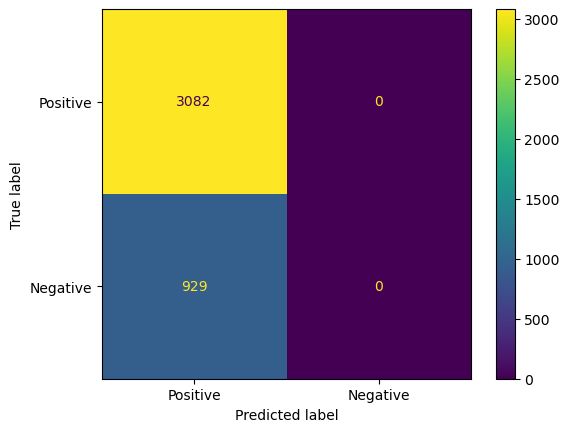

Predictions saved to 'lstm_predictions_for_ensemble.csv'.


In [45]:
# Create time series data for LSTM (7-day sequences)
def create_dataset(data, target_reg, target_class, time_step=7):
    X, y_reg, y_class = [], [], []
    max_len = min(len(data), len(target_reg), len(target_class)) - time_step - 1
    for i in range(max_len):
        X.append(data[i:(i + time_step), :])
        y_reg.append(target_reg[i + time_step])  # Case count for regression
        y_class.append(target_class[i + time_step])  # Binary outcome
    return np.array(X), np.array(y_reg), np.array(y_class)

# Now, pass the resampled data to the create_dataset function
X, y_reg, y_class = create_dataset(X_resampled, target_case_count_resampled.values, y_resampled, time_step=7)

# Train-test split
X_train, X_test, y_train_reg, y_test_reg, y_train_class, y_test_class = train_test_split(
    X, y_reg, y_class, test_size=0.2, random_state=42, shuffle=False
)

# Define LSTM Model for Multi-task Learning (Regression + Classification)
class LSTMRegressionClassification(nn.Module):
    def __init__(self, input_size):
        super(LSTMRegressionClassification, self).__init__()
        self.lstm = nn.LSTM(input_size, 100, num_layers=2, batch_first=True, dropout=0.3)
        self.fc_reg = nn.Linear(100, 1)  # Output layer for regression
        self.fc_class = nn.Linear(100, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary output
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out_reg = self.fc_reg(out[:, -1, :])  # Regression output
        out_class = self.sigmoid(self.fc_class(out[:, -1, :]))  # Classification output
        return out_reg, out_class

# Instantiate model, define loss and optimizer
input_size = X_train.shape[2]  # Number of features
model = LSTMRegressionClassification(input_size)
criterion_reg = nn.MSELoss()
criterion_class = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_reg_tensor = torch.Tensor(y_train_reg).unsqueeze(1)  # Reshape for regression
y_train_class_tensor = torch.Tensor(y_train_class).unsqueeze(1)  # Reshape for classification
X_test_tensor = torch.Tensor(X_test)
y_test_reg_tensor = torch.Tensor(y_test_reg).unsqueeze(1)
y_test_class_tensor = torch.Tensor(y_test_class).unsqueeze(1)

# Train the model
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    outputs_reg, outputs_class = model(X_train_tensor)
    
    # Calculate losses for both regression and classification
    loss_reg = criterion_reg(outputs_reg, y_train_reg_tensor)
    loss_class = criterion_class(outputs_class, y_train_class_tensor)
    
    # Combine losses (weighted sum)
    loss = (0.7 * loss_reg) + (0.3 * loss_class)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs_reg, test_outputs_class = model(X_test_tensor)
            test_loss_reg = criterion_reg(test_outputs_reg, y_test_reg_tensor)
            test_loss_class = criterion_class(test_outputs_class, y_test_class_tensor)
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Test Loss (Reg/Cls): {test_loss_reg.item():.4f}/{test_loss_class.item():.4f}')
        
# Evaluate regression and classification performance separately
with torch.no_grad():
    lstm_preds_reg, lstm_preds_class_prob = model(X_test_tensor)  # Predictions for regression and classification
    lstm_preds_class = (lstm_preds_class_prob > 0.5).float()  # Binary classification

# Performance Metrics for Regression
mse = mean_squared_error(y_test_reg, lstm_preds_reg)
mae = mean_absolute_error(y_test_reg, lstm_preds_reg)
print(f'MSE (Regression): {mse:.4f}, MAE (Regression): {mae:.4f}')

# Performance Metrics for Classification
accuracy = accuracy_score(y_test_class, lstm_preds_class.numpy())
precision = precision_score(y_test_class, lstm_preds_class.numpy(), average='macro', zero_division=0)
recall = recall_score(y_test_class, lstm_preds_class.numpy(), average='macro')
f1 = f1_score(y_test_class, lstm_preds_class.numpy(), average='macro')
roc_auc = roc_auc_score(y_test_class, lstm_preds_class_prob.numpy(), multi_class='ovr')

print(f'Accuracy (Classification): {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test_class, lstm_preds_class)
ConfusionMatrixDisplay(cm, display_labels=['Positive', 'Negative']).plot()
plt.show()

# Save predictions to CSV
predictions_df = pd.DataFrame({
    'True_Label_Regression': y_test_reg,  # True values for regression (case count)
    'Predicted_Regression': lstm_preds_reg.squeeze().numpy(),  # Predicted values for regression
    'True_Label_Classification': y_test_class,  # True values for classification (binary)
    'Predicted_Classification': lstm_preds_class.squeeze().numpy(),  # Predicted values for classification
    'Predicted_Classification_Prob': lstm_preds_class_prob.squeeze().numpy()  # Classification probabilities
})

# Save the predictions to CSV
predictions_df.to_csv('lstm_predictions_for_ensemble.csv', index=False)
print("Predictions saved to 'lstm_predictions_for_ensemble.csv'.")